In [1]:
from qiskit import *
from qiskit.tools.visualization import *
from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate
import numpy as np
import scipy
import math

In [2]:
# Define the Coefficient Matrix and the Solution Vector of your Linear equations here 

coefficient_matrix_A = np.matrix([[1,-1/3, 2],[-1/3,1,8], [1/3,1,4]])

B_vector = np.array([0,1,9]) #B_vector should be transformed to row vector from column vector

In [3]:
# To make the matrices a 2^n x 2^n matrices we use padding functions on both coefficient_matrix_A to the closest 2^n x2^n

def next_power_of_2(n):
    return int(2 ** np.ceil(np.log2(n)))

def pad_matrix_to_equal_power_of_2(matrix):
    # Get the shape of the input matrix
    rows, cols = matrix.shape

    # Compute the next power of 2 for both dimensions
    new_rows = next_power_of_2(rows)
    new_cols = next_power_of_2(cols)

    # Ensure that the padding is to an equal power of 2
    max_dim = max(new_rows, new_cols)

    # Compute the padding sizes
    pad_rows = max_dim - rows
    pad_cols = max_dim - cols

    # Pad the matrix
    padded_matrix = np.pad(matrix, ((0, pad_rows), (0, pad_cols)))

    return padded_matrix


In [4]:
# To make the matrices a 2^n x 2^n matrices we use padding functions on both B_vector to the closest 2^n x 1 dimension matrix

def zero_padding(arr):
    # Check if the length of the array is already a power of 2
    n = len(arr)
    if n & (n - 1) == 0:
        return arr  # No padding needed
    
    # Find the next power of 2 greater than or equal to the length of the array
    next_power_of_two = 2**int(np.ceil(np.log2(n)))
    
    # Calculate the number of zeros to pad
    num_zeros_to_pad = next_power_of_two - n
    
    # Create a new array with zero padding
    padded_arr = np.concatenate((arr, np.zeros(num_zeros_to_pad)))
    
    return padded_arr


In [5]:
# Coefficeint Matrix A may or may not be Hermitian, So defining a Function to transform arbritary A into a Hermitian with scaled elements

def make_hermitian_with_rescaling(coefficient_matrix):
    
    hermitian_matrix = coefficient_matrix + np.conj(coefficient_matrix.T)
    
    # Applying padding function to the hermitian matrix
    
    padded_hermitian_matrix = pad_matrix_to_equal_power_of_2(hermitian_matrix)
    
    #Extracting the eigenvalues and eigenvectors of the hermitian_matrix
    eigen_val, eigen_vec = scipy.linalg.eig(padded_hermitian_matrix)
    
    padded_hermitian_matrix = padded_hermitian_matrix.astype(float)
    
    #Rescaling the hermitian_matrix so that the eigenvalues lie between -1 and 1 to avoid ill-conditioned situations
    rescaled_hermitian_matrix = padded_hermitian_matrix/ max(np.real(eigen_val))
    
    return rescaled_hermitian_matrix

In [6]:
#Converting the given Coefficient Matrix A to an equivalent Hermitian Matrix

hermitian_A = make_hermitian_with_rescaling(coefficient_matrix_A)

print(hermitian_A)

[[ 0.13635228 -0.04545076  0.15907766  0.        ]
 [-0.04545076  0.13635228  0.61358524  0.        ]
 [ 0.15907766  0.61358524  0.54540911  0.        ]
 [ 0.          0.          0.          0.        ]]


In [7]:
# Finding the Condition Number for the given hermitian_A

kappa = np.linalg.cond(hermitian_A)

print(f"Condition Number (Kappa) = {kappa}")

Condition Number (Kappa) = inf


In [8]:
# Extracting the Eigenvalues and EigenVectors of the given hermitian_A

eigen_val, eigen_vec = scipy.linalg.eig(hermitian_A)

print(f"Eigenvalues are: {eigen_val} \n")

print(f"Eigenvectors are: {eigen_vec}")

Eigenvalues are: [-0.3417721 +0.j  0.15988576+0.j  1.        +0.j  0.        +0.j] 

Eigenvectors are: [[-0.26619402 -0.95647308  0.11958254  0.        ]
 [-0.76979742  0.28560769  0.57082413  0.        ]
 [ 0.5801316  -0.05989564  0.81231757  0.        ]
 [ 0.          0.          0.          1.        ]]


In [9]:
# Defining a function that normalizes the vector B

def normalizing_vector(B_vector):
    
    #Calculating the Norm factor
    norm_factor = scipy.linalg.norm(B_vector)
    
    #Calculating the Normalized Vector
    normalized_B = B_vector/ norm_factor
    
    return normalized_B

In [10]:
# Applying padding to the vector B

padded_vector_B = zero_padding(B_vector)

normalized_vector_B = normalizing_vector(padded_vector_B)

print(normalized_vector_B)

[0.         0.11043153 0.99388373 0.        ]


In [11]:
# Calculating the Size of B vector
length_of_b = np.size(normalized_vector_B)

print(f"Length of vector B = {length_of_b}")

Length of vector B = 4


In [12]:
# Paramenetrs to determine the number of qubits require to represent the vector B

n_b = np.ceil(np.log2(length_of_b))

print(f"The value of n_b = {n_b}")

The value of n_b = 2.0


In [18]:
# Setting the crucial parameters for the given problem

# Parameter for the Hamiltonian Time Evolution
time_evolution_T = (3*math.pi)/4

#Parameter for the number of qubits require for Quantum Phase Estimation
n_qpe = int(2**n_b)

#Parameters are strictly setted for 2x2 dimention of coefficient matrices

In [19]:
# Defining a Function to manufacture a Quantum Circuit for the given Problem

def construct_quantum_circuit(n_qpe, n_b, normalized_vector_B):
    
    #Constructing the Required Quantum Registers
    
    #Ancilla Register or Auxillary Register for Controlled Rotations
    ancilla_register = QuantumRegister(1, name = 'ancilla')
    
    #Clock Register for Quantum Phase Estimation
    clock_register = QuantumRegister(n_qpe, name = 'clock')
    
    #b Regsiter for Solution Vector
    b_register = QuantumRegister(n_b, name = 'b')
    
    # Classical Register to store the measurement values
    
    bit_register = ClassicalRegister(1+n_qpe+n_b, name = 'measurement_bits')
    
    #Paramenetrs are strictly for a generalized 2x2 matrices
    
    #Constructing the Quantum Circuit
    init_circuit = QuantumCircuit(ancilla_register, clock_register, b_register, bit_register)
    
    return init_circuit, ancilla_register, clock_register, b_register

prepared_circuit = construct_quantum_circuit(n_qpe, n_b, normalized_vector_B)

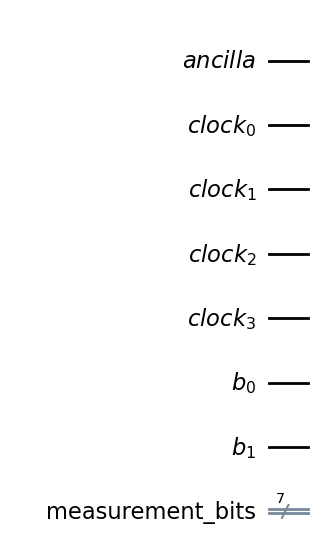

In [20]:
#Extracting the Quantum Circuit from the Prepared_Circuit
quantum_circuit =  prepared_circuit[0]

quantum_circuit.draw('mpl')

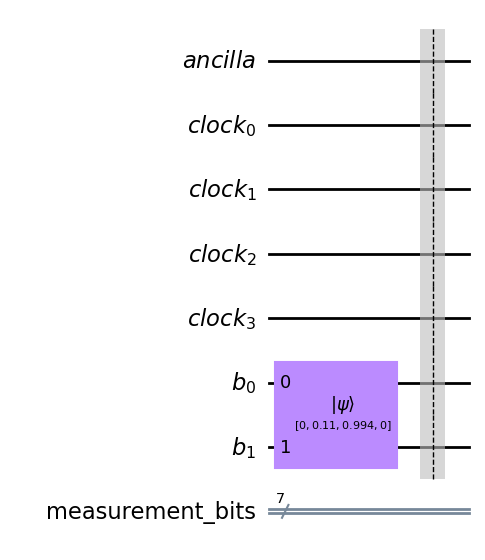

In [21]:
#State Preparations for the given Problem

b_register = prepared_circuit[3]

#Initializing the Quantum Ciruit

quantum_circuit.initialize(normalized_vector_B, b_register)

quantum_circuit.barrier()

quantum_circuit.draw('mpl')

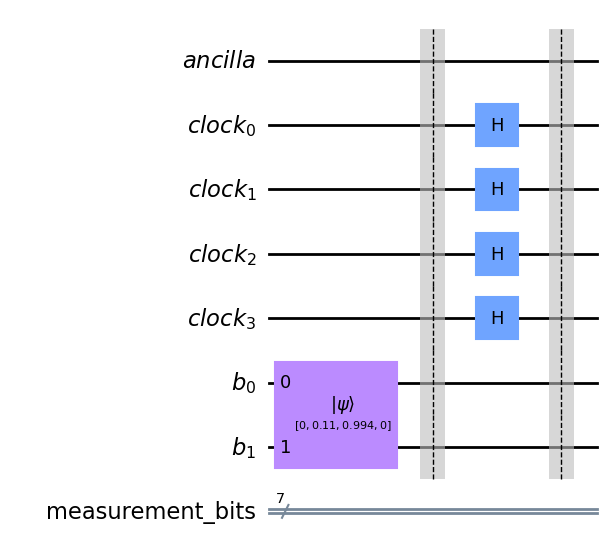

In [22]:
#To Start the Quantum Phase Estimation segment, first hadamard gates are require to be placed in clock_register

clock_register = prepared_circuit[2]

for i in range(n_qpe):
    
    #Placing Hadamard Gates in the Clock registers
    quantum_circuit.h(clock_register[i])
    
quantum_circuit.barrier()

quantum_circuit.draw('mpl')

In [23]:
#Defining a Function that Transform the hermitian_A into a Hamiltonian of an Unitary Matrix.

def convert_hermitian_A_into_Unitary_gate(hermitian_A, time_evolution_T):
    
    #Convert the hermitian_A to unitary matrix through exponentiantion
    
    U_matrix = scipy.linalg.expm(1j * hermitian_A * time_evolution_T)
    
    #Converting the Unitary Matrix to Unitary Operator using Qiskit
    
    U_operator = UnitaryGate(U_matrix)
    
    U_operator.name = "$U$"
    
    return U_operator

In [24]:
#Constructing the 2nd Phase of the QPE circuit

U_gate = convert_hermitian_A_into_Unitary_gate(hermitian_A, time_evolution_T)

for i in range(n_qpe):
    
    Upow = U_gate.power(2**(n_qpe-1-i))
    ctrl_Upow = Upow.control()
    quantum_circuit.append(ctrl_Upow, [clock_register[i], *b_register])
    
quantum_circuit.barrier()

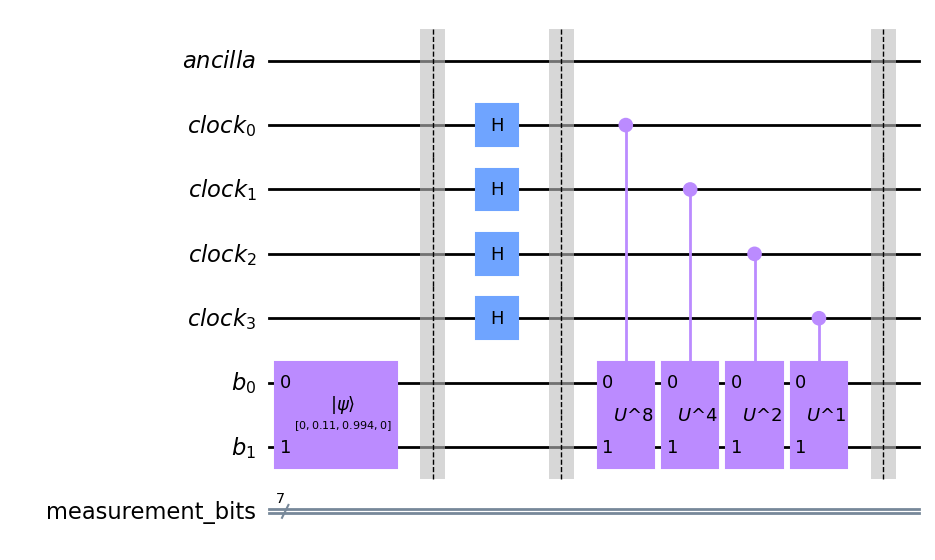

In [25]:
quantum_circuit.draw('mpl')

In [26]:
#Constructing the 3rd phase of QPE circuit

#This phase is where we apply the Inverse Quantum Fourier Transform

quantum_circuit = quantum_circuit.compose(QFT(n_qpe, inverse = True), [*clock_register])

quantum_circuit.barrier()

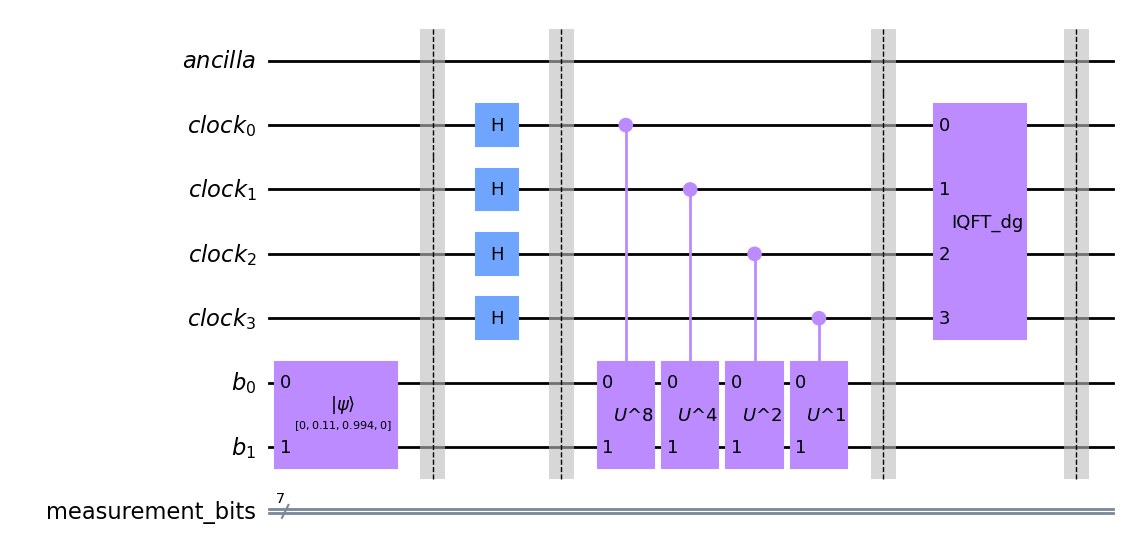

In [27]:
quantum_circuit.draw('mpl')